# 02 - CSP+SVM

Este notebook implementa el método CSP+SVM.

## Objetivos

1. **Filter Bank CSP (FBCSP)**: Aplicación de CSP en múltiples bandas de frecuencia
2. **Optimización de hiperparámetros**: Grid Search para encontrar mejores parámetros del SVM
3. **Regularización CSP**: Ledoit-Wolf para mayor estabilidad
4. **Optimización de componentes**: Determinación automática del número óptimo de componentes CSP
5. **Selección de características**: Filtrado de características más discriminativas
6. **Validación cruzada estratificada**: Evaluación más robusta
7. **Preprocesamiento avanzado**: Filtrado por múltiples bandas de frecuencia
8. **Ensemble methods**: Combinación de múltiples modelos


In [16]:
# Importaciones
import numpy as np
from pathlib import Path
import warnings
from time import time
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, train_test_split,
    GridSearchCV, cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal

# CSP para Python y carga de archivos EEGLAB
try:
    from mne.decoding import CSP
    import mne
    # Configurar logging de MNE para silenciar mensajes informativos
    mne.set_log_level('ERROR')  # Solo muestra errores, silencia INFO, WARNING, DEBUG
except ImportError:
    print("Instalando mne...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "mne"])
    from mne.decoding import CSP
    import mne
    # Configurar logging de MNE para silenciar mensajes informativos
    mne.set_log_level('ERROR')  # Solo muestra errores, silencia INFO, WARNING, DEBUG

# Para descarga de Google Drive y manejo de ZIP
try:
    import gdown
except ImportError:
    print("Instalando gdown...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "gdown"])
    import gdown

import zipfile
import shutil
import pickle
import json

# Configuración del proyecto
CONFIG = {
    'n_subjects': 15,
    'n_channels': 64,
    'n_trials_per_subject': 22,
    'n_total_trials': 660,
    'sampling_rate': 128,
    'trial_duration': 9.0,
    'trial_window': (-3.0, 6.0),
    'n_samples_per_trial': 1152,
    'filter_low': 8,
    'filter_high': 30,
    'random_seed': 42,
    'data_dir': 'data',
    'models_dir': 'models',
    'results_dir': 'results',
    
    # Configuración de mejoras
    'use_fbcsp': True,  # Filter Bank CSP
    'frequency_bands': [
        (4, 8),    # Theta
        (8, 13),   # Alpha
        (13, 20),  # Beta bajo
        (20, 30),  # Beta alto
        (30, 40)   # Gamma
    ],
    'n_components_range': (2, 10),  # Rango para optimizar componentes CSP
    'csp_reg': 'ledoit_wolf',  # Regularización CSP
    'optimize_hyperparams': True,  # Optimizar hiperparámetros SVM
    'use_feature_selection': True,  # Selección de características
    'feature_selection_k': 20,  # Número de características a seleccionar
    'use_ensemble': True,  # Usar ensemble methods
    'google_drive_folder_id': '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW',
    'google_drive_url': 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW?usp=drive_link',
    # Nombres esperados de los archivos ZIP en Google Drive
    'zip_left_names': ['imag_left.zip', 'left_imag.zip', 'left.zip'],
    'zip_right_names': ['imag_right.zip', 'right_imag.zip', 'right.zip']
}

# Crear directorios necesarios si no existen
for dir_name in [CONFIG['data_dir'], CONFIG['models_dir'], CONFIG['results_dir']]:
    Path(dir_name).mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('processed').mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('left_imag').mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('right_imag').mkdir(exist_ok=True, parents=True)

print("Importaciones completadas")
print(f"Configuración:")
print(f"- Filter Bank CSP: {CONFIG['use_fbcsp']}")
print(f"- Bandas de frecuencia: {CONFIG['frequency_bands']}")
print(f"- Regularización CSP: {CONFIG['csp_reg']}")
print(f"- Optimización hiperparámetros: {CONFIG['optimize_hyperparams']}")
import pandas as pd
print(f"- Selección de características: {CONFIG['use_feature_selection']}")


Importaciones completadas
Configuración:
- Filter Bank CSP: True
- Bandas de frecuencia: [(4, 8), (8, 13), (13, 20), (20, 30), (30, 40)]
- Regularización CSP: ledoit_wolf
- Optimización hiperparámetros: True
- Selección de características: True


In [17]:
# Función auxiliar para leer archivos EEGLAB (.set)
def load_eeglab_file(file_path):
    """Lee archivos EEGLAB (.set) usando MNE como método principal. Retorna solo los datos."""
    try:
        # Método 1: Intentar leer como epochs (más común en EEGLAB)
        try:
            epochs = mne.read_epochs_eeglab(str(file_path), verbose=False)
            data = epochs.get_data()  # Formato: (n_epochs, n_channels, n_times)
            
            # Si hay múltiples epochs, necesitamos manejar esto correctamente
            if len(data.shape) == 3:
                n_epochs, n_channels, n_times = data.shape
                
                # Si solo hay una epoch, extraerla
                if n_epochs == 1:
                    data = data[0]  # (n_channels, n_times)
                else:
                    # Para CSP-SVM, tomar la primera epoch
                    first_epoch = data[0]
                    first_std = np.std(first_epoch)
                    
                    # Si la primera epoch tiene poca variación, buscar una con más variación
                    if first_std < 1e-6:
                        # Buscar epoch con mayor variación
                        epoch_stds = [np.std(data[i]) for i in range(n_epochs)]
                        best_epoch_idx = np.argmax(epoch_stds)
                        data = data[best_epoch_idx]
                    else:
                        data = first_epoch
            
            data = np.asarray(data, dtype=np.float64)
            
            # Verificar que los datos no sean constantes
            data_std = np.std(data)
            if data_std < 1e-10:
                raise ValueError("Datos constantes después de extracción, intentando método alternativo")
            
            return data
        except Exception as epochs_error:
            # Método 2: Intentar leer como raw
            try:
                raw = mne.io.read_raw_eeglab(str(file_path), preload=True, verbose=False)
                data = raw.get_data()  # Formato: (n_channels, n_times)
                data = np.asarray(data, dtype=np.float64)
                
                # Verificar que los datos no sean constantes
                data_std = np.std(data)
                if data_std < 1e-10:
                    raise ValueError("Datos raw constantes, intentando método alternativo")
                
                return data
            except Exception as raw_error:
                # Método 3: Usar scipy.io.loadmat directamente
                from scipy.io import loadmat
                
                mat = loadmat(str(file_path), simplify_cells=False)
                
                # Buscar estructura EEG
                if 'EEG' not in mat:
                    raise ValueError(f"Campo 'EEG' no encontrado en {file_path.name}")
                
                eeg_struct = mat['EEG']
                if not isinstance(eeg_struct, np.ndarray) or eeg_struct.size == 0:
                    raise ValueError(f"Estructura EEG vacía en {file_path.name}")
                
                # Acceder al objeto EEG
                eeg_item = eeg_struct[0, 0] if eeg_struct.ndim >= 2 else eeg_struct.item()
                
                # Extraer el campo 'data'
                if not hasattr(eeg_item, 'dtype') or not eeg_item.dtype.names or 'data' not in eeg_item.dtype.names:
                    raise ValueError(f"Campo 'data' no encontrado en estructura EEG")
                
                data_field = eeg_item['data']
                
                # Extraer datos recursivamente
                if isinstance(data_field, np.ndarray):
                    if data_field.size == 1:
                        data = data_field.item()
                    else:
                        data = data_field
                    
                    # Extraer recursivamente si es estructurado
                    depth = 0
                    max_depth = 10
                    while isinstance(data, np.ndarray) and hasattr(data, 'dtype') and depth < max_depth:
                        depth += 1
                        if data.dtype.names:
                            if 'data' in data.dtype.names:
                                data = data['data']
                                if isinstance(data, np.ndarray) and data.size == 1:
                                    data = data.item()
                            else:
                                break
                        elif np.issubdtype(data.dtype, np.number):
                            break
                        else:
                            break
                    
                    data = np.asarray(data, dtype=np.float64)
                    
                    # Manejar formas 2D y 3D
                    if len(data.shape) == 3:
                        # EEGLAB típicamente usa (channels, time, epochs)
                        if data.shape[0] < data.shape[1]:
                            data = data[:, :, 0]  # Tomar primera epoch
                        else:
                            data = data[0, :, :]  # Tomar primera epoch
                    
                    # Verificar orientación para 2D
                    if len(data.shape) == 2:
                        # Si parece (time, channels), transponer
                        if data.shape[0] > data.shape[1] * 2:
                            data = data.T
                    
                    # Verificación final
                    final_std = np.std(data)
                    if final_std < 1e-10:
                        raise ValueError(f"Datos finales son constantes en {file_path.name}")
                    
                    return data
                else:
                    raise ValueError(f"Campo 'data' no es un array numpy, tipo: {type(data_field)}")
                    
    except Exception as e:
        raise ValueError(f"Error al leer archivo {file_path.name}: {str(e)}")

# Función para descargar datos del Google Drive si no existen
def download_data_from_drive(data_dir='data', folder_id=None, config=None):
    """Descarga archivos ZIP del Google Drive y los extrae en las carpetas correspondientes"""
    if config is None:
        config = CONFIG
    if folder_id is None:
        folder_id = config.get('google_drive_folder_id', '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')
    
    data_path = Path(data_dir)
    left_dir = data_path / 'left_imag'
    right_dir = data_path / 'right_imag'
    
    # Crear directorios si no existen
    left_dir.mkdir(exist_ok=True, parents=True)
    right_dir.mkdir(exist_ok=True, parents=True)
    
    # Verificar si ya existen archivos (formato EEGLAB: .set y .fdt)
    # Nota: Los archivos .fdt son binarios asociados a .set, solo contamos .set
    left_files = list(left_dir.glob('*.set'))
    right_files = list(right_dir.glob('*.set'))
    
    if len(left_files) > 0 and len(right_files) > 0:
        print(f"Datos encontrados: {len(left_files)} archivos en left_imag, {len(right_files)} archivos en right_imag")
        return
    
    print("No se encontraron datos locales. Descargando ZIPs del Google Drive...")
    print(f"URL: {config.get('google_drive_url', 'N/A')}")
    
    try:
        # Descargar carpeta completa del Google Drive
        print(f"Descargando carpeta desde Google Drive...")
        print("Esto puede tomar varios minutos...")
        
        # Descargar la carpeta completa (esto descargará todos los archivos, incluyendo los ZIP)
        temp_download_dir = data_path / 'temp_downloads'
        temp_download_dir.mkdir(exist_ok=True, parents=True)
        
        gdown.download_folder(
            id=folder_id,
            output=str(temp_download_dir),
            quiet=False,
            use_cookies=False
        )
        
        # Buscar archivos ZIP descargados
        zip_files = list(temp_download_dir.glob('*.zip'))
        
        if len(zip_files) == 0:
            # Buscar recursivamente en subcarpetas
            zip_files = list(temp_download_dir.rglob('*.zip'))
        
        print(f"Encontrados {len(zip_files)} archivo(s) ZIP")
        
        # Identificar y extraer cada ZIP
        left_zip = None
        right_zip = None
        
        # Buscar ZIPs por nombre
        zip_left_names = config.get('zip_left_names', ['imag_left.zip', 'left_imag.zip', 'left.zip'])
        zip_right_names = config.get('zip_right_names', ['imag_right.zip', 'right_imag.zip', 'right.zip'])
        
        for zip_file in zip_files:
            zip_name_lower = zip_file.name.lower()
            # Buscar ZIP izquierdo
            if not left_zip:
                for name_pattern in zip_left_names:
                    if name_pattern.lower() in zip_name_lower or 'left' in zip_name_lower:
                        left_zip = zip_file
                        print(f"   Identificado ZIP izquierdo: {zip_file.name}")
                        break
            # Buscar ZIP derecho
            if not right_zip:
                for name_pattern in zip_right_names:
                    if name_pattern.lower() in zip_name_lower or 'right' in zip_name_lower:
                        right_zip = zip_file
                        print(f"   Identificado ZIP derecho: {zip_file.name}")
                        break
        
        # Si no se encontraron por nombre, intentar usar los primeros dos ZIPs
        if not left_zip and len(zip_files) >= 2:
            left_zip = zip_files[0]
            right_zip = zip_files[1]
            print(f"Usando primeros dos ZIPs encontrados: {left_zip.name}, {right_zip.name}")
        elif not left_zip and len(zip_files) == 1:
            print(f"Solo se encontró un ZIP: {zip_files[0].name}")
            print(f"Asumiendo que contiene ambos conjuntos de datos...")
            left_zip = zip_files[0]
        
        # Extraer ZIPs de manera inteligente (evitar carpetas anidadas)
        def extract_zip_smartly(zip_file, target_dir, zip_name):
            """Extrae un ZIP evitando crear carpetas anidadas"""
            temp_extract = target_dir.parent / f'temp_extract_{zip_name}'
            temp_extract.mkdir(exist_ok=True, parents=True)
            
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(temp_extract)
            
            # Buscar si hay una carpeta left_imag o right_imag en la raíz
            nested_dir = None
            for item in temp_extract.iterdir():
                if item.is_dir() and (item.name.lower() in ['left_imag', 'right_imag', 'left', 'right']):
                    nested_dir = item
                    break
            
            # Si encontramos una carpeta anidada, mover su contenido
            if nested_dir:
                print(f"Detectada carpeta '{nested_dir.name}' dentro del ZIP")
                # Mover todos los archivos de la carpeta anidada
                for file in nested_dir.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(nested_dir)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
                print(f"Contenido movido de {nested_dir.name} a {target_dir.name}/")
            else:
                # Si no hay carpeta anidada, mover todos los archivos directamente
                for file in temp_extract.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(temp_extract)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
            
            # Limpiar directorio temporal
            shutil.rmtree(temp_extract)
        
        if left_zip:
            print(f"Extrayendo {left_zip.name} a left_imag/...")
            extract_zip_smartly(left_zip, left_dir, 'left')
            print(f"Extracción completada: left_imag/")
        
        if right_zip:
            print(f"Extrayendo {right_zip.name} a right_imag/...")
            extract_zip_smartly(right_zip, right_dir, 'right')
            print(f"Extracción completada: right_imag/")
        
        # Limpiar archivos temporales
        if temp_download_dir.exists():
            shutil.rmtree(temp_download_dir)
            print(f"Archivos temporales eliminados")
        
        # Verificar archivos extraídos (formato EEGLAB: .set y .fdt)
        # Nota: Los archivos .fdt son binarios asociados a .set, solo contamos .set
        downloaded_left = list(left_dir.glob('*.set'))
        downloaded_right = list(right_dir.glob('*.set'))
        
        if len(downloaded_left) > 0 or len(downloaded_right) > 0:
            print(f"Descarga y extracción completada:")
            print(f"- left_imag: {len(downloaded_left)} archivos .set")
            print(f"- right_imag: {len(downloaded_right)} archivos .set")
            if len(downloaded_left) > 0:
                fdt_files_left = list(left_dir.glob('*.fdt'))
                if len(fdt_files_left) > 0:
                    print(f"- left_imag: {len(fdt_files_left)} archivos .fdt asociados")
            if len(downloaded_right) > 0:
                fdt_files_right = list(right_dir.glob('*.fdt'))
                if len(fdt_files_right) > 0:
                    print(f"- right_imag: {len(fdt_files_right)} archivos .fdt asociados")
        else:
            print(f"Los ZIPs se extrajeron pero no se encontraron archivos .set")
            print(f"Verifica la estructura de los archivos ZIP")
        
    except Exception as e:
        print(f"Error al descargar o extraer: {e}")
        print(f"Por favor, descarga los archivos ZIP manualmente desde:")
        print(f"{config.get('google_drive_url', 'N/A')}")
        print(f"Y extrae:")
        print(f"- imag_left.zip (o similar) en: {left_dir}/")
        print(f"- imag_right.zip (o similar) en: {right_dir}/")
        raise

# Función de preprocesamiento (reutilizada del notebook básico)
def load_and_preprocess_eeg_data(data_dir='data', config=None):
    """Carga y preprocesa datos EEG. Si los archivos procesados ya existen, los carga directamente."""
    data_path = Path(data_dir)
    processed_dir = data_path / 'processed'
    processed_dir.mkdir(exist_ok=True, parents=True)
    
    if all((processed_dir / f).exists() for f in ['X_train.npy', 'X_test.npy', 'y_train.npy', 'y_test.npy']):
        print("Cargando datos preprocesados existentes...")
        X_train = np.load(processed_dir / 'X_train.npy')
        X_test = np.load(processed_dir / 'X_test.npy')
        y_train = np.load(processed_dir / 'y_train.npy')
        y_test = np.load(processed_dir / 'y_test.npy')
        print(f"Datos cargados: Train={X_train.shape}, Test={X_test.shape}")
        return X_train, X_test, y_train, y_test
    
    print("Datos procesados no encontrados. Cargando y procesando datos originales...")
    if config is None:
        config = {'n_channels': 64, 'n_samples_per_trial': 1152, 'random_seed': 42}
    
    left_dir = data_path / 'left_imag'
    right_dir = data_path / 'right_imag'
    left_dir.mkdir(exist_ok=True, parents=True)
    right_dir.mkdir(exist_ok=True, parents=True)
    
    X_left, X_right = [], []
    
    # Buscar y cargar archivos .set (formato EEGLAB)
    # Nota: Los archivos .fdt se cargan automáticamente con el .set cuando se usa MNE
    for file_path in sorted(left_dir.glob('*.set')):
        if file_path.is_file():
            try:
                # Leer archivo EEGLAB (.set)
                data = load_eeglab_file(file_path)
                if len(data.shape) == 2:
                    # Asegurar formato correcto: (channels, time)
                    if data.shape[0] > data.shape[1]: 
                        data = data.T
                    X_left.append(data)
            except Exception as e:
                print(f"Error cargando {file_path.name}: {e}")
                pass
    
    for file_path in sorted(right_dir.glob('*.set')):
        if file_path.is_file():
            try:
                # Leer archivo EEGLAB (.set)
                data = load_eeglab_file(file_path)
                if len(data.shape) == 2:
                    # Asegurar formato correcto: (channels, time)
                    if data.shape[0] > data.shape[1]: 
                        data = data.T
                    X_right.append(data)
            except Exception as e:
                print(f"Error cargando {file_path.name}: {e}")
                pass
    
    # Si no hay datos, intentar descargarlos
    if len(X_left) == 0 or len(X_right) == 0:
        print(f"No se encontraron datos en las carpetas. Intentando descargar del Google Drive...")
        download_data_from_drive(data_dir, config.get('google_drive_folder_id') if config else None, config)
        
        # Intentar cargar nuevamente después de la descarga
        X_left, X_right = [], []
        for file_path in sorted(left_dir.glob('*.set')):
            if file_path.is_file():
                try:
                    # Leer archivo EEGLAB (.set)
                    data = load_eeglab_file(file_path)
                    if len(data.shape) == 2:
                        # Asegurar formato correcto: (channels, time)
                        if data.shape[0] > data.shape[1]: 
                            data = data.T
                        X_left.append(data)
                except Exception as e:
                    print(f"Error cargando {file_path.name}: {e}")
                    pass
        
        for file_path in sorted(right_dir.glob('*.set')):
            if file_path.is_file():
                try:
                    # Leer archivo EEGLAB (.set)
                    data = load_eeglab_file(file_path)
                    if len(data.shape) == 2:
                        # Asegurar formato correcto: (channels, time)
                        if data.shape[0] > data.shape[1]: 
                            data = data.T
                        X_right.append(data)
                except Exception as e:
                    print(f"Error cargando {file_path.name}: {e}")
                    pass
    
    # Validar que ahora sí se encontraron datos reales
    if len(X_left) == 0:
        raise FileNotFoundError(
            f"ERROR: No se pudieron descargar ni encontrar datos reales en {left_dir}\n"
            f"Por favor, descarga los datos manualmente desde:\n"
            f"{(config or {}).get('google_drive_url', 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')}\n"
            f"Y colócalos en: {left_dir}/"
        )
    
    if len(X_right) == 0:
        raise FileNotFoundError(
            f"ERROR: No se pudieron descargar ni encontrar datos reales en {right_dir}\n"
            f"Por favor, descarga los datos manualmente desde:\n"
            f"{(config or {}).get('google_drive_url', 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')}\n"
            f"Y colócalos en: {right_dir}/"
        )
    
    print(f"Datos reales encontrados: {len(X_left)} trials izquierdos, {len(X_right)} trials derechos")
    
    X_left_processed = []
    for trial in X_left:
        if trial.shape[0] == config['n_channels'] and trial.shape[1] >= config['n_samples_per_trial']:
            X_left_processed.append(trial[:, :config['n_samples_per_trial']])
        elif trial.shape[1] == config['n_channels'] and trial.shape[0] >= config['n_samples_per_trial']:
            X_left_processed.append(trial[:config['n_samples_per_trial'], :].T)
    
    X_right_processed = []
    for trial in X_right:
        if trial.shape[0] == config['n_channels'] and trial.shape[1] >= config['n_samples_per_trial']:
            X_right_processed.append(trial[:, :config['n_samples_per_trial']])
        elif trial.shape[1] == config['n_channels'] and trial.shape[0] >= config['n_samples_per_trial']:
            X_right_processed.append(trial[:config['n_samples_per_trial'], :].T)
    
    X = np.array(X_left_processed + X_right_processed)
    y = np.array([0] * len(X_left_processed) + [1] * len(X_right_processed))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=config.get('random_seed', 42), stratify=y
    )
    
    np.save(processed_dir / 'X_train.npy', X_train)
    np.save(processed_dir / 'X_test.npy', X_test)
    np.save(processed_dir / 'y_train.npy', y_train)
    np.save(processed_dir / 'y_test.npy', y_test)
    
    print(f"Datos procesados y guardados: Train={X_train.shape}, Test={X_test.shape}")
    return X_train, X_test, y_train, y_test

# Función para filtrado de bandas de frecuencia
def bandpass_filter(X, low, high, sampling_rate=128, order=4):
    """Aplica un filtro pasabanda a los datos EEG"""
    nyquist = sampling_rate / 2
    low_norm = low / nyquist
    high_norm = high / nyquist
    
    # Diseñar filtro Butterworth
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')
    
    # Aplicar filtro a cada trial y canal
    X_filtered = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_filtered[i, j, :] = signal.filtfilt(b, a, X[i, j, :])
    
    return X_filtered

# Función Filter Bank CSP
def apply_fbcsp(X, y, frequency_bands, n_components=4, csp_reg='ledoit_wolf'):
    """Aplica Filter Bank CSP: CSP en múltiples bandas de frecuencia"""
    all_features = []
    csp_transformers = []
    
    print(f"Aplicando Filter Bank CSP con {len(frequency_bands)} bandas de frecuencia...")
    
    for idx, (low, high) in enumerate(frequency_bands):
        print(f"Procesando banda {idx+1}/{len(frequency_bands)}: {low}-{high} Hz")
        
        # Filtrar señal
        X_filtered = bandpass_filter(X, low, high, sampling_rate=CONFIG['sampling_rate'])
        
        # Aplicar CSP
        csp = CSP(n_components=n_components, reg=csp_reg, log=True, norm_trace=False)
        features = csp.fit_transform(X_filtered, y)
        
        all_features.append(features)
        csp_transformers.append(csp)
    
    # Concatenar características de todas las bandas
    X_fbcsp = np.hstack(all_features)
    
    print(f"Filter Bank CSP completado")
    print(f"Características por banda: {n_components}")
    print(f"Total de características: {X_fbcsp.shape[1]}")
    
    return X_fbcsp, csp_transformers

# Función para aplicar FBCSP a nuevos datos
def transform_fbcsp(X, csp_transformers, frequency_bands):
    """Aplica las transformaciones CSP aprendidas a nuevos datos"""
    all_features = []
    
    for idx, (low, high) in enumerate(frequency_bands):
        X_filtered = bandpass_filter(X, low, high, sampling_rate=CONFIG['sampling_rate'])
        features = csp_transformers[idx].transform(X_filtered)
        all_features.append(features)
    
    return np.hstack(all_features)

# Funciones de evaluación
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusión"):
    """Visualiza la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['MI-L', 'MI-R'], 
                yticklabels=['MI-L', 'MI-R'])
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()

print("Funciones auxiliares definidas")


Funciones auxiliares definidas


## Carga de Datos

Este notebook carga y preprocesa los datos automáticamente si no están disponibles.

In [18]:
# Cargar y preprocesar datos (automáticamente si no existen)
X_train, X_test, y_train, y_test = load_and_preprocess_eeg_data(
    data_dir=CONFIG['data_dir'], 
    config=CONFIG
)

print("Datos cargados exitosamente")
print(f"Entrenamiento: {X_train.shape}")
print(f"Prueba: {X_test.shape}")
print(f"Clases entrenamiento: {np.bincount(y_train)}")
print(f"Clases prueba: {np.bincount(y_test)}")

Datos procesados no encontrados. Cargando y procesando datos originales...
No se encontraron datos en las carpetas. Intentando descargar del Google Drive...
No se encontraron datos locales. Descargando ZIPs del Google Drive...
URL: https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW?usp=drive_link
Descargando carpeta desde Google Drive...
Esto puede tomar varios minutos...


Retrieving folder contents


Processing file 1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb left_imag.zip
Processing file 1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2 right_imag.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb
From (redirected): https://drive.google.com/uc?id=1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb&confirm=t&uuid=be871fd9-f92c-4ef4-a4f1-acd3290b5d8f
To: /Users/manueljurado/doctorado/eeg-mi-deep-learning/data/temp_downloads/left_imag.zip
100%|██████████| 239M/239M [01:26<00:00, 2.74MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2
From (redirected): https://drive.google.com/uc?id=1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2&confirm=t&uuid=c8a00426-cdf0-45ff-bbab-987ffed39a67
To: /Users/manueljurado/doctorado/eeg-mi-deep-learning/data/temp_downloads/right_imag.zip
100%|██████████| 237M/237M [01:31<00:00, 2.59MB/s] 
Download completed


Encontrados 2 archivo(s) ZIP
   Identificado ZIP izquierdo: left_imag.zip
   Identificado ZIP derecho: right_imag.zip
Extrayendo left_imag.zip a left_imag/...
Detectada carpeta 'left_imag' dentro del ZIP
Contenido movido de left_imag a left_imag/
Extracción completada: left_imag/
Extrayendo right_imag.zip a right_imag/...
Detectada carpeta 'right_imag' dentro del ZIP
Contenido movido de right_imag a right_imag/
Extracción completada: right_imag/
Archivos temporales eliminados
Descarga y extracción completada:
- left_imag: 20 archivos .set
- right_imag: 20 archivos .set
- left_imag: 20 archivos .fdt asociados
- right_imag: 20 archivos .fdt asociados
Datos reales encontrados: 20 trials izquierdos, 20 trials derechos
Datos procesados y guardados: Train=(32, 64, 1152), Test=(8, 64, 1152)
Datos cargados exitosamente
Entrenamiento: (32, 64, 1152)
Prueba: (8, 64, 1152)
Clases entrenamiento: [16 16]
Clases prueba: [4 4]


## Filter Bank CSP (FBCSP)

Aplicamos CSP en múltiples bandas de frecuencia para capturar información de diferentes rangos espectrales.

In [19]:
# Optimizar número de componentes CSP
print("Optimizando número de componentes CSP...")
best_n_components = 4
best_score = 0

n_comp_range = range(CONFIG['n_components_range'][0], CONFIG['n_components_range'][1] + 1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['random_seed'])

# Para acelerar, solo probamos algunos valores representativos
test_components = [2, 4, 6, 8]

for n_comp in test_components:
    if CONFIG['use_fbcsp']:
        X_fbcsp, _ = apply_fbcsp(X_train, y_train, CONFIG['frequency_bands'], 
                                  n_components=n_comp, csp_reg=CONFIG['csp_reg'])
        X_features = X_fbcsp
    else:
        # CSP simple
        csp = CSP(n_components=n_comp, reg=CONFIG['csp_reg'], log=True, norm_trace=False)
        X_features = csp.fit_transform(X_train, y_train)
    
    # Evaluar con SVM básico
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=10, gamma='scale', random_state=CONFIG['random_seed']))
    ])
    
    scores = cross_val_score(pipeline, X_features, y_train, cv=skf, scoring='accuracy')
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_n_components = n_comp
    
    print(f"{n_comp} componentes: {mean_score:.4f} ± {scores.std():.4f}")

print(f"Mejor número de componentes: {best_n_components} (score: {best_score:.4f})")
CONFIG['best_n_components'] = best_n_components

Optimizando número de componentes CSP...
Aplicando Filter Bank CSP con 5 bandas de frecuencia...
Procesando banda 1/5: 4-8 Hz
Procesando banda 2/5: 8-13 Hz
Procesando banda 3/5: 13-20 Hz
Procesando banda 4/5: 20-30 Hz
Procesando banda 5/5: 30-40 Hz
Filter Bank CSP completado
Características por banda: 2
Total de características: 10
2 componentes: 0.5095 ± 0.1457
Aplicando Filter Bank CSP con 5 bandas de frecuencia...
Procesando banda 1/5: 4-8 Hz
Procesando banda 2/5: 8-13 Hz
Procesando banda 3/5: 13-20 Hz
Procesando banda 4/5: 20-30 Hz
Procesando banda 5/5: 30-40 Hz
Filter Bank CSP completado
Características por banda: 4
Total de características: 20
4 componentes: 0.7190 ± 0.0610
Aplicando Filter Bank CSP con 5 bandas de frecuencia...
Procesando banda 1/5: 4-8 Hz
Procesando banda 2/5: 8-13 Hz
Procesando banda 3/5: 13-20 Hz
Procesando banda 4/5: 20-30 Hz
Procesando banda 5/5: 30-40 Hz
Filter Bank CSP completado
Características por banda: 6
Total de características: 30
6 componentes: 0.7

In [20]:
# Aplicar Filter Bank CSP
if CONFIG['use_fbcsp']:
    X_train_features, csp_transformers = apply_fbcsp(
        X_train, y_train,
        CONFIG['frequency_bands'],
        n_components=CONFIG['best_n_components'],
        csp_reg=CONFIG['csp_reg']
    )
    
    X_test_features = transform_fbcsp(X_test, csp_transformers, CONFIG['frequency_bands'])
else:
    # CSP simple
    csp = CSP(n_components=CONFIG['best_n_components'], reg=CONFIG['csp_reg'], 
              log=True, norm_trace=False)
    X_train_features = csp.fit_transform(X_train, y_train)
    X_test_features = csp.transform(X_test)
    csp_transformers = [csp]

print(f"\nCaracterísticas extraídas:")
print(f"Train: {X_train_features.shape}")
print(f"Test: {X_test_features.shape}")

Aplicando Filter Bank CSP con 5 bandas de frecuencia...
Procesando banda 1/5: 4-8 Hz
Procesando banda 2/5: 8-13 Hz
Procesando banda 3/5: 13-20 Hz
Procesando banda 4/5: 20-30 Hz
Procesando banda 5/5: 30-40 Hz
Filter Bank CSP completado
Características por banda: 8
Total de características: 40

Características extraídas:
Train: (32, 40)
Test: (8, 40)


## Selección de Características

Seleccionamos las características más discriminativas usando F-test.

In [21]:
# Selección de características
if CONFIG['use_feature_selection']:
    print("Seleccionando mejores características...")
    
    # Determinar k basado en número de características disponibles
    max_k = min(CONFIG['feature_selection_k'], X_train_features.shape[1] // 2)
    
    selector = SelectKBest(score_func=f_classif, k=max_k)
    X_train_selected = selector.fit_transform(X_train_features, y_train)
    X_test_selected = selector.transform(X_test_features)
    
    print(f"Seleccionadas {max_k} características de {X_train_features.shape[1]}")
    
    X_train_final = X_train_selected
    X_test_final = X_test_selected
    feature_selector = selector
else:
    X_train_final = X_train_features
    X_test_final = X_test_features
    feature_selector = None
    print("Usando todas las características")

Seleccionando mejores características...
Seleccionadas 20 características de 40


## Optimización de Hiperparámetros del SVM

Usamos Grid Search para encontrar los mejores parámetros del clasificador SVM.

In [22]:
# Optimización de hiperparámetros
if CONFIG['optimize_hyperparams']:
    print("Optimizando hiperparámetros del SVM...")
    
    # Silenciar mensajes informativos de MNE durante la optimización
    # Estos mensajes aparecen cuando CSP calcula el rango de los datos
    import logging
    mne_logger = logging.getLogger('mne')
    original_level = mne_logger.level
    mne_logger.setLevel(logging.ERROR)
    
    try:
        # Pipeline base
        base_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(random_state=CONFIG['random_seed']))
        ])
        
        # Grid de parámetros
        param_grid = {
            'svm__C': [0.1, 1, 10, 100],
            'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'svm__kernel': ['linear', 'rbf']
        }
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['random_seed'])
        
        grid_search = GridSearchCV(
            base_pipeline,
            param_grid,
            cv=skf,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train_final, y_train)
        
        print(f"\nMejores parámetros encontrados:")
        for param, value in grid_search.best_params_.items():
            print(f"{param}: {value}")
        print(f"Mejor score (CV): {grid_search.best_score_:.4f}")
        
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
    finally:
        # Restaurar el nivel de logging original
        mne_logger.setLevel(original_level)
else:
    # Usar parámetros por defecto
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=10, gamma='scale', random_state=CONFIG['random_seed']))
    ])
    best_params = {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
    print("Usando parámetros por defecto (sin optimización)")

Optimizando hiperparámetros del SVM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Mejores parámetros encontrados:
svm__C: 1
svm__gamma: 0.01
svm__kernel: rbf
Mejor score (CV): 0.8143


## Entrenamiento y Evaluación Final

Entrenamos el modelo optimizado y evaluamos su rendimiento.

In [23]:
# Entrenar modelo final
print("Entrenando modelo final optimizado...")
start_time = time()

best_pipeline.fit(X_train_final, y_train)

training_time = time() - start_time

# Predecir
y_pred_train = best_pipeline.predict(X_train_final)
y_pred_test = best_pipeline.predict(X_test_final)

# Calcular métricas
train_metrics = calculate_metrics(y_train, y_pred_train)
test_metrics = calculate_metrics(y_test, y_pred_test)

print(f"\nEntrenamiento completado en {training_time:.2f} segundos")
print(f"\n{'='*60}")
print("RESULTADOS FINALES")
print(f"{'='*60}")
print(f"\nEntrenamiento:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print(f"\nPrueba:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Entrenando modelo final optimizado...

Entrenamiento completado en 0.01 segundos

RESULTADOS FINALES

Entrenamiento:
accuracy: 0.8125
precision: 0.8636
recall: 0.8125
f1_score: 0.8057
cohen_kappa: 0.6250

Prueba:
accuracy: 0.1250
precision: 0.1000
recall: 0.1250
f1_score: 0.1111
cohen_kappa: -0.7500


## Validación Cruzada Estratificada

Realizamos validación cruzada para obtener una estimación más robusta del rendimiento.

In [24]:
# Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['random_seed'])

cv_scores = cross_validate(
    best_pipeline,
    X_train_final,
    y_train,
    cv=skf,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
    return_train_score=True
)

print("Resultados de Validación Cruzada (5-fold):")
print(f"\nAccuracy:")
print(f"Train: {cv_scores['train_accuracy'].mean():.4f} ± {cv_scores['train_accuracy'].std():.4f}")
print(f"Test:  {cv_scores['test_accuracy'].mean():.4f} ± {cv_scores['test_accuracy'].std():.4f}")

print(f"\nF1-score:")
print(f"Train: {cv_scores['train_f1_weighted'].mean():.4f} ± {cv_scores['train_f1_weighted'].std():.4f}")
print(f"Test:  {cv_scores['test_f1_weighted'].mean():.4f} ± {cv_scores['test_f1_weighted'].std():.4f}")

Resultados de Validación Cruzada (5-fold):

Accuracy:
Train: 0.8126 ± 0.0281
Test:  0.8143 ± 0.1170

F1-score:
Train: 0.8054 ± 0.0310
Test:  0.8013 ± 0.1293


## Ensemble Methods

Creamos un ensemble de múltiples modelos para mejorar la robustez.

In [25]:
# Ensemble methods (opcional)
if CONFIG['use_ensemble']:
    print("Creando ensemble de modelos...")
    
    # Crear múltiples modelos con diferentes configuraciones
    models = [
        ('svm_rbf', Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', C=best_params.get('svm__C', 10), 
                      gamma=best_params.get('svm__gamma', 'scale'), 
                      random_state=CONFIG['random_seed'], probability=True))
        ])),
        ('svm_linear', Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='linear', C=best_params.get('svm__C', 10), 
                      random_state=CONFIG['random_seed'], probability=True))
        ])),
        ('lda', Pipeline([
            ('scaler', StandardScaler()),
            ('lda', LinearDiscriminantAnalysis())
        ]))
    ]
    
    # Voting Classifier
    ensemble = VotingClassifier(estimators=models, voting='soft')
    
    # Entrenar ensemble
    ensemble.fit(X_train_final, y_train)
    
    # Evaluar ensemble
    y_pred_ensemble_train = ensemble.predict(X_train_final)
    y_pred_ensemble_test = ensemble.predict(X_test_final)
    
    ensemble_train_metrics = calculate_metrics(y_train, y_pred_ensemble_train)
    ensemble_test_metrics = calculate_metrics(y_test, y_pred_ensemble_test)
    
    print(f"\nEnsemble creado y entrenado")
    print(f"\nResultados del Ensemble:")
    print(f"Train Accuracy: {ensemble_train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy:  {ensemble_test_metrics['accuracy']:.4f}")
    
    # Usar ensemble si mejora
    if ensemble_test_metrics['accuracy'] > test_metrics['accuracy']:
        print(f"\nEnsemble mejora el rendimiento. Usando ensemble.")
        final_model = ensemble
        final_train_metrics = ensemble_train_metrics
        final_test_metrics = ensemble_test_metrics
        y_pred_final_test = y_pred_ensemble_test
    else:
        print(f"\nModelo individual es mejor. Usando modelo individual.")
        final_model = best_pipeline
        final_train_metrics = train_metrics
        final_test_metrics = test_metrics
        y_pred_final_test = y_pred_test
else:
    final_model = best_pipeline
    final_train_metrics = train_metrics
    final_test_metrics = test_metrics
    y_pred_final_test = y_pred_test
    print("Ensemble deshabilitado. Usando modelo individual.")

Creando ensemble de modelos...

Ensemble creado y entrenado

Resultados del Ensemble:
Train Accuracy: 0.9688
Test Accuracy:  0.1250

Modelo individual es mejor. Usando modelo individual.


## Visualización de Resultados

Visualizamos las métricas y la matriz de confusión del mejor modelo.

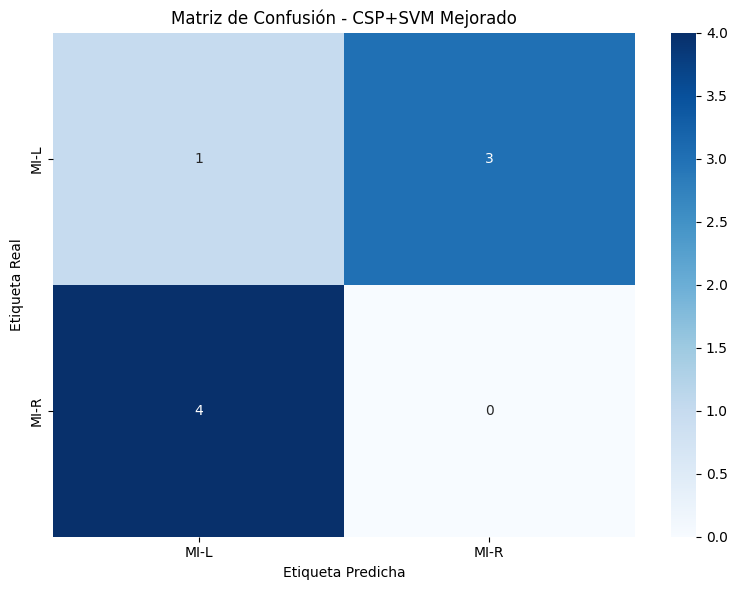

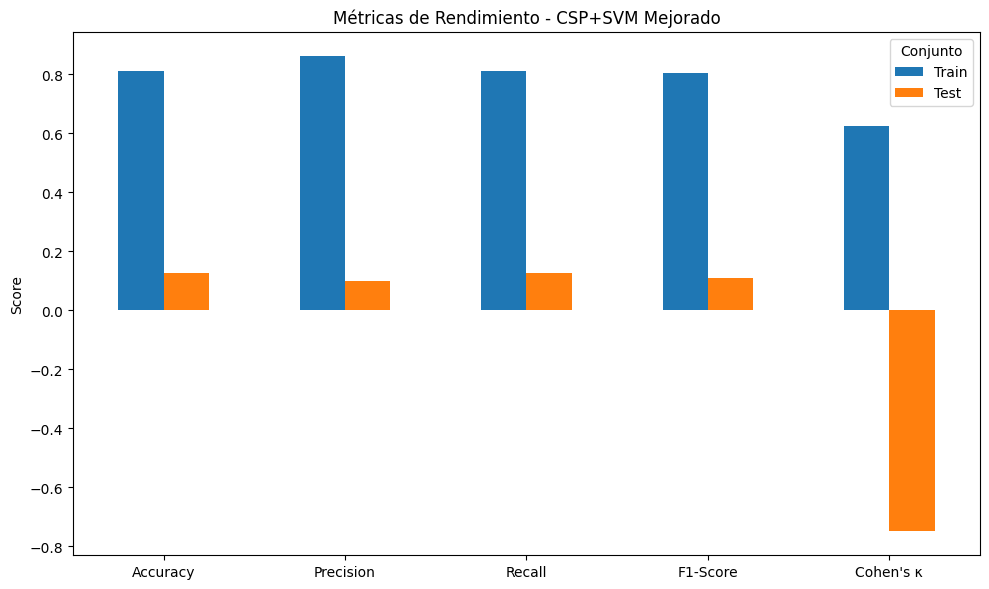

In [26]:
# Visualizar matriz de confusión
fig = plot_confusion_matrix(y_test, y_pred_final_test, 
                            title="Matriz de Confusión - CSP+SVM Mejorado")
plt.show()

# Comparar métricas
metrics_df = pd.DataFrame({
    'Train': [final_train_metrics['accuracy'], final_train_metrics['precision'],
              final_train_metrics['recall'], final_train_metrics['f1_score'],
              final_train_metrics['cohen_kappa']],
    'Test': [final_test_metrics['accuracy'], final_test_metrics['precision'],
             final_test_metrics['recall'], final_test_metrics['f1_score'],
             final_test_metrics['cohen_kappa']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', "Cohen's κ"])

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Métricas de Rendimiento - CSP+SVM Mejorado')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Conjunto')
plt.tight_layout()
plt.show()

In [27]:
# Guardar resultados
output_dir = Path(CONFIG['results_dir'])
output_dir.mkdir(exist_ok=True)

# Guardar modelo y transformadores
model_data = {
    'model': final_model,
    'csp_transformers': csp_transformers,
    'feature_selector': feature_selector,
    'config': CONFIG,
    'best_params': best_params if CONFIG['optimize_hyperparams'] else {},
    'best_n_components': CONFIG.get('best_n_components', 4)
}

with open(output_dir / 'csp_svm_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Guardar resultados
results_to_save = {
    'train': {k: float(v) for k, v in final_train_metrics.items()},
    'test': {k: float(v) for k, v in final_test_metrics.items()},
    'cv_scores': {k: [float(x) for x in v] if isinstance(v, np.ndarray) else v 
                  for k, v in cv_scores.items()},
    'config': CONFIG,
    'best_params': best_params if CONFIG['optimize_hyperparams'] else {},
    'training_time': float(training_time)
}

with open(output_dir / 'csp_svm_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"\nModelo y resultados guardados en {output_dir}/")
print(f"- Modelo: csp_svm_model.pkl")
print(f"- Resultados: csp_svm_results.json")


Modelo y resultados guardados en results/
- Modelo: csp_svm_model.pkl
- Resultados: csp_svm_results.json
